In [250]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import stats

Read Gold (D1) data:

In [251]:
dfG=pd.read_csv('quotes/XAUUSD.csv') 
dfG.columns=['date','time','open','high','low','close','volume'] 
dfG=dfG[['date','open','close','low','high']]
dfG.set_index('date',inplace=True)
dfG=dfG.drop(['high','low','open'], axis=1) 
dfG.rename(columns={'close':'closeG'},inplace=True)
dfG.index=pd.to_datetime(dfG.index)

Read Silver (D1) data:

In [252]:
dfS=pd.read_csv('quotes/XAGUSD.csv') 
dfS.columns=['date','time','open','high','low','close','volume'] 
dfS=dfS[['date','open','close','low','high']]
dfS.set_index('date',inplace=True)
dfS=dfS.drop(['high','low','open'], axis=1) 
dfS.rename(columns={'open':'openS','close':'closeS'},inplace=True)
dfS.index=pd.to_datetime(dfS.index)

Merging of 2 frames by indexes:

In [253]:
df=pd.merge(dfS,dfG,how='inner',left_index=True,right_index=True)
df=df.dropna()

Convert prices to returns (1) by log function and taking differences (2):

In [254]:
df=df[['closeS','closeG']].apply(np.log)
df=df.diff(axis=0,periods=1)
df.rename(columns={'closeS':'RetS','closeG':'RetG'},inplace=True)
df=df.dropna()
df.describe()

,RetS,RetG
count,2047.000000,2047.000000
mean,-0.000238,-0.000026
std,0.015010,0.009312
min,-0.142630,-0.095693
25%,-0.007517,-0.004821
50%,0.000051,0.000167
75%,0.006982,0.004714
max,0.070627,0.047798


Normalize returns (3) in order to make stable regression and factor analysis. Remove nulls:

In [255]:
df=(df-df.min())/(df.max()-df.min()) 
df=df[df>0]

Max/min are slowly changing parameters which have to be updated on the regular basis. PDF:

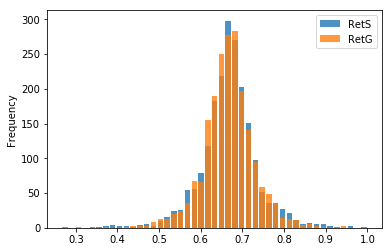

In [256]:
df[['RetS','RetG']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8)
plt.show()

Increments between orange and blue represent market inefficiencies. Look at the outliers:

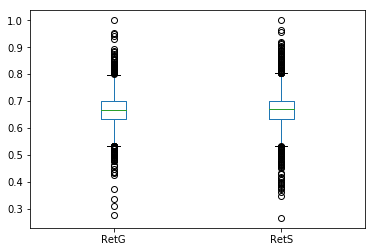

In [257]:
df.dropna(inplace=True)
df[['RetG','RetS']].boxplot(grid=False) 
plt.show()

Look at Pearson correlation and significance of H0 hypothesis:

In [258]:
pc=sc.stats.pearsonr(list(df['RetG']),list(df['RetS']))

print('Gold vs Silver return correlation (Pearson):',round(pc[0],2))
print('Gold vs Silver return 2-tailed p-value:',round(pc[1],2))

Gold vs Silver return correlation (Pearson): 0.81
Gold vs Silver return 2-tailed p-value: 0.0


Correlation is good enough for arbitrage opportunities. Create scatter plot of Gold vs Silver:

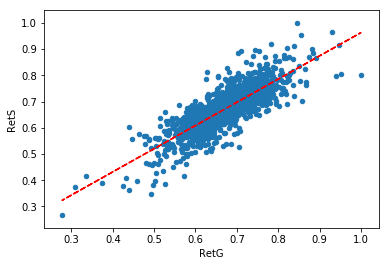

Hedge factor (slope): 0.89
Constant (intercept): 0.08


In [259]:
df.plot.scatter(x='RetG',y='RetS') 

x=list(df['RetG'])
y=list(df['RetS'])

z=np.polyfit(x,y,1)
p=np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.show()

hedge=round(p[1],2)

print('Hedge factor (slope):',hedge)
print('Constant (intercept):',round(p[0],2))

Hedge factor is used to construct long-short portfolio:

In [260]:
df['Long/Short']=df['RetG']-hedge*df['RetS']
df=df.dropna()

Create visual representation. Two ranges of 1 sigma and 3 sigma are added:

In [261]:
description=df['Long/Short'].describe()

mean=description[1]
std=description[2]

u1=round(mean+1*std,2)
u2=round(mean+3*std,2)

l1=round(mean-1*std,2)
l2=round(mean-3*std,2)

Create figure.Recent point is marked by 'bold':

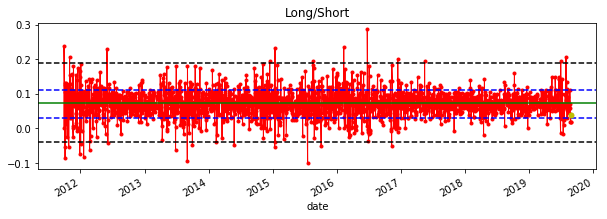

In [262]:
plt.figure(figsize=(10,3))
df['Long/Short'].plot(color='r',marker='o',linewidth=1, markersize=3)

plt.axhline(y=mean,color='g',linestyle='-')

plt.axhline(y=u1,color='b',linestyle='--')
plt.axhline(y=l1,color='b',linestyle='--')
plt.axhline(y=u2,color='black',linestyle='--')
plt.axhline(y=l2,color='black',linestyle='--')
plt.plot(df['Long/Short'].index[-1], df['Long/Short'].values[-1],'oy',markersize=5)

plt.title('Long/Short')
plt.show()

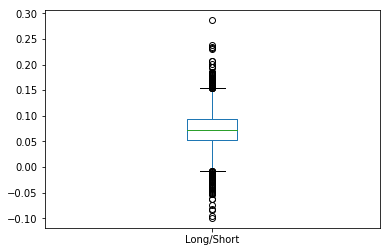

In [263]:
df['Long/Short'].plot.box(grid=False) 
plt.show()

Relative return seems to be mean reverting to the parity. Now we check the relative return for stationarity by ADF test: 

In [264]:
z=df['Long/Short'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -47.360321
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


We can reject the null hypothesis - strongly negative ADF statistic. Probability distribution of relative return:

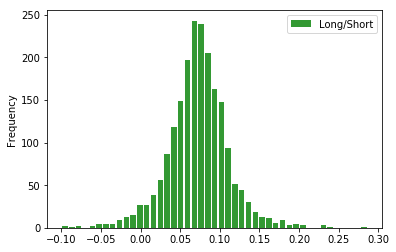

In [265]:
df[['Long/Short']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,color='g',alpha=0.8)
plt.show()

We may define the average mean reversion time in the frame of ARIMA. First rescale the reverting series by substracting the average. Define differences of relative returns (price acceleration) and shift first time series:

In [266]:
df.drop(['RetS','RetG'],axis=1,inplace=True) 
df['Difference']=df['Long/Short'].diff() 
df['Long/Short']=df['Long/Short'].shift(1,axis = 0)
df=df.dropna()

Show Person correlation and significance of H0 hypothesis: 

In [267]:
pc=sc.stats.pearsonr(list(df['Long/Short']),list(df['Difference']))
print('Gold vs Silver return correlation (Pearson):',round(pc[0],2))
print('Gold vs Silver return 2-tailed p-value:',round(pc[1],2))

Gold vs Silver return correlation (Pearson): -0.72
Gold vs Silver return 2-tailed p-value: 0.0


Scatter plot:

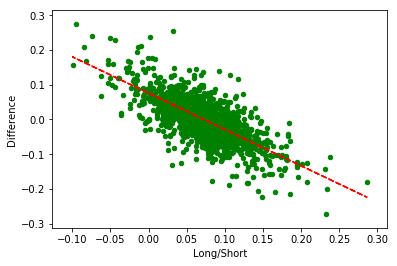

Slope: -1.05
Intercept: 0.08


In [268]:
df.plot.scatter(x='Long/Short',y='Difference',color='g') 

x=list(df['Long/Short'])
y=list(df['Difference'])

z=np.polyfit(x,y,1)
p=np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.show()

print('Slope:',round(p[1],2))
print('Intercept:',round(p[0],2))

Calcultation of mean reversion decay time. It is the recommended time of long-short position hold:

In [269]:
print('Mean reversion time:',int(round(-math.log(2)/list(z)[0])),'day')

Mean reversion time: 1 day
